This is a basic intro kernel about TS and classical approaches to TS forecast
The main idea is from the conference of Dr. Ahmed Abdulaal, Data Scientist, eBay (https://www.youtube.com/watch?v=xhuv8NaaroA&list=PLaF0NRp5ez3iPeT3JMyhqfGVV-9cqWL3Z&index=4&t=0s)


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install pmdarima

## **Import Data**

In [ ]:
# Function to read data into Kernel

ts = pd.read_csv("../input/" + 'nab/realAdExchange/realAdExchange/exchange-2_cpc_results' + ".csv")
ts.head()

## **Convert to  time series**

In [ ]:
ts['timestamp']= pd.to_datetime(ts['timestamp']) #convert the col to timestamo data
ts.set_index('timestamp',drop=True,inplace=True) #set it as the index
ts=ts.resample('h').mean() #sampling
ts.columns=['cpc'] #set the column name as cpc
ts=ts['cpc']
ts.head()

## **Missing values**

In [ ]:
ts.isna().sum()
# 25 observations are missing 

In [ ]:

ts.index[ts.isna()] #printng out the missing value location
# we see that most of the missing values are on 02.09.2011

In [ ]:
ts.plot(grid=True,figsize =(19,8))
# in this plot we can see the missing values

In [ ]:

ts_clean = ts.loc[ts.index < '2011-09-02'] # selecting the missing values
ts_clean.fillna(method='pad', inplace=True)  # this is equivalent to both method='ffill' and .ffill()
ts_clean.head()

In [ ]:
ts_clean.plot(grid=True, figsize=(19,8)) # cleaned data

## Splitting the data and visualising it

In [ ]:
# in practise 70-15-15 is the best way to split the data into Test-Train-Final test(not used for CV or training)
n_obs = ts_clean.shape[0]  #shape -1512
split1= ts_clean.index[int(0.7*n_obs)]  # split based on index
split2= ts_clean.index[int(0.85*n_obs)]  # split based on index

train_ts = ts_clean.loc[ts_clean.index <= split1]
val_ts = ts_clean.loc[(ts_clean.index > split1) & (ts_clean.index <= split2)]
test_ts = ts_clean.loc[ts_clean.index > split2]

In [ ]:
pd.concat([train_ts.rename('Train'),test_ts.rename('Test'),val_ts.rename('Validation')],axis=1).plot(grid=True,figsize =(18,9),legend =True)

# Time series - Basics

A time series is thought to be an aggregate or combination of these four components.

* Level      : The average value in the series.
* Trend      : The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise      : The random variation in the series.





All series have a level and noise. The trend and seasonality components are optional.

These components combine either additively or multiplicatively.

**Additive Model**
An additive model suggests that the components are added together as follows:

*y(t) = Level + Trend + Seasonality + Noise*

An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line.
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

**Multiplicative Model**
A multiplicative model suggests that the components are multiplied together as follows:

*y(t) = Level * Trend * Seasonality * Noise*


A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.A nonlinear trend is a curved line.
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(train_ts,model='additive',freq =24) # frequency of 24hrs -- hourly data set
plt.figure(figsize=(18,9))
plt.plot(decomposition.trend)


In [ ]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualize 
plt.figure(figsize=(18,9))
plt.subplot(411)
plt.plot(train_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Check for stationarity:

Most time series models require the data to be stationary. A time series is said to be stationary if its statistical properties such as mean, variance & covariance remain constant over time. The above graphs gives the info that the TS data has both trend & seasonality. That means it is not stationary.

Apart from this visual method, other way is to perform a statistical test namely Dickey-Fuller Hypothesis testing:

**Null Hypothesis:** The series is not stationary.
**Alternate Hypothesis:** The series is stationary.

Note:
* If ADF statistic < critical value => Reject the Null hypothesis
* If ADF statistic > critical value => Failed to reject the Null hypothesis

If the p-value is less than 0.05, we reject the null hypothesis 

In [ ]:

from statsmodels.tsa.stattools import adfuller

X = train_ts.values
adf_result = adfuller(X,regression="c")
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

print('Critical Values: The ‘1%’, ‘10%’ and ‘5%’ values are the critical values for 99%, 90% and 95% confidence levels')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if adf_result[0] < adf_result[4]['5%']:
    print('H0 hypothesis rejected : Stationary time series')
else:
    print('H1 hypothesis accepted : Non-Stationary time series')

Here we see that seasonality is present in the data so then the apt model would be SARIMA
Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

**Trend Elements**
There are three trend elements that require configuration which is the same for ARMA too:

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.

**Seasonal Elements**
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.

Together, the notation for an SARIMA model is specified as:

SARIMA(p,d,q)(P,D,Q)m



In [ ]:
resid = residual.dropna()

adf_resid = adfuller(resid,regression="c")
print ('ADF Statistic is :', adf_resid[0])
print ('p-value is :', adf_resid[1])

Autocorrelation is the correlation of a signal with a delayed copy — or a lag — of itself as a function of the delay.
When plotting the value of the ACF for increasing lags (a plot called a correlogram), the values tend to degrade to zero quickly for stationary time series 

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resid = residual.dropna()

plt.figure(figsize=(18,9))
plt.subplot(211)
plot_acf(resid, lags=52, ax=plt.gca())
plt.grid()
plt.subplot(212)
plot_pacf(resid, lags=52, ax=plt.gca())
plt.grid()
plt.show()

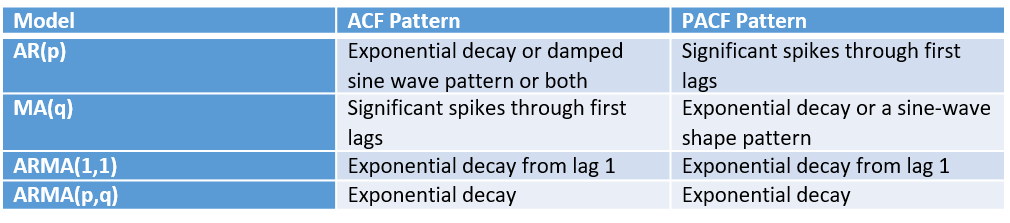

Here we have 3 significant spikes in the ACF model anmd only 1 in the PACF model.
- MA(3)
- AR(1)

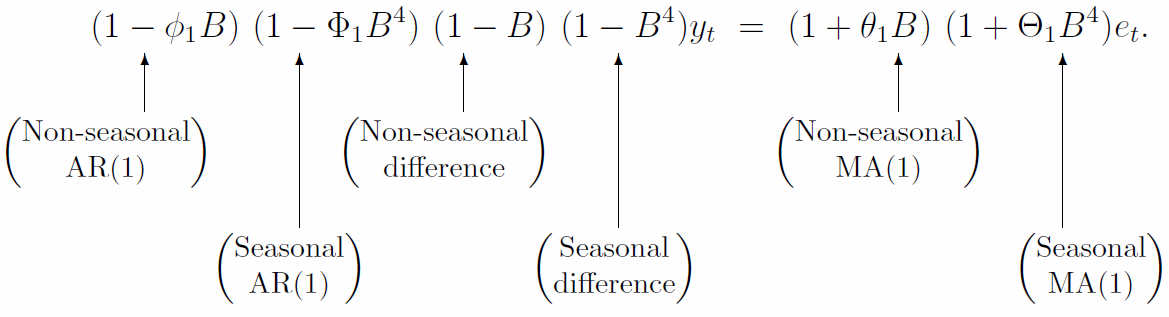

Rules for srelecting the parameters:
1. https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima
2. https://people.duke.edu/~rnau/arimrule.htm

In [ ]:
import pmdarima as pm
stepwise_model = pm.auto_arima(train_ts, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

In [ ]:
arima = pm.auto_arima(train_ts, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=50,
                      seasonal=True, m=24)

The preference is given to the fit that has low values for AIC / BIC

# Model Fitting

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

model = SARIMAX(train_ts, order=(3, 1, 3), seasonal_order=(1, 0, 1, 24))
start = time.time()
model_fit = model.fit(dis=0)
print('fitting complete after {} seconds'.format(time.time()-start))

In [ ]:
model_fit.summary()

# Forecasting

In [ ]:

f_steps = val_ts.shape[0]
results = model_fit.get_forecast(f_steps)

forecasts = pd.concat([results.predicted_mean, results.conf_int(alpha=0.05)], axis=1) 
forecasts.columns = ['Forecasts', 'Lower 95% CI', 'Upper 95% CI']

forecasts.head()

# Validation

In [ ]:
rmse = ((val_ts.values - results.predicted_mean)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual)')
plt.plot(val_ts, label='Future (actual)')
plt.plot(forecasts['Forecasts'], label='Forecast')
plt.fill_between(forecasts.index, forecasts['Lower 95% CI'], forecasts['Upper 95% CI'], color='0.8',label='95% confidence interval')
plt.legend()
plt.grid()
plt.title('RMSE: '+ str(rmse))

* Model1 - From the lecture - RMSE -0.001634420146630526
* Model2 - Without any limits for p,q - RMSE: 0.0006874025223576442
* Model3 - With limits - RMSE: 0.001420134501793429